In [176]:
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split # Sklearn package's randomized data splitting function
import math # log function is inside this library

### 1.	Read the column description and ensure you understand each attribute well

In [178]:
df_data_raw = pd.read_csv("Bank_Personal_Loan_Modelling.csv")  
df_data_raw

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [179]:
df_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Comment: no columns with missing data, all column are numeric (including catergorical features)

In [180]:
df_data_y = df_data_raw['Personal Loan']
df_data_x = df_data_raw.copy()
df_data_x.drop(['ID','Personal Loan'],axis=1, inplace=True)

### 2.	Study the data distribution in each attribute, share your findings (15 marks)

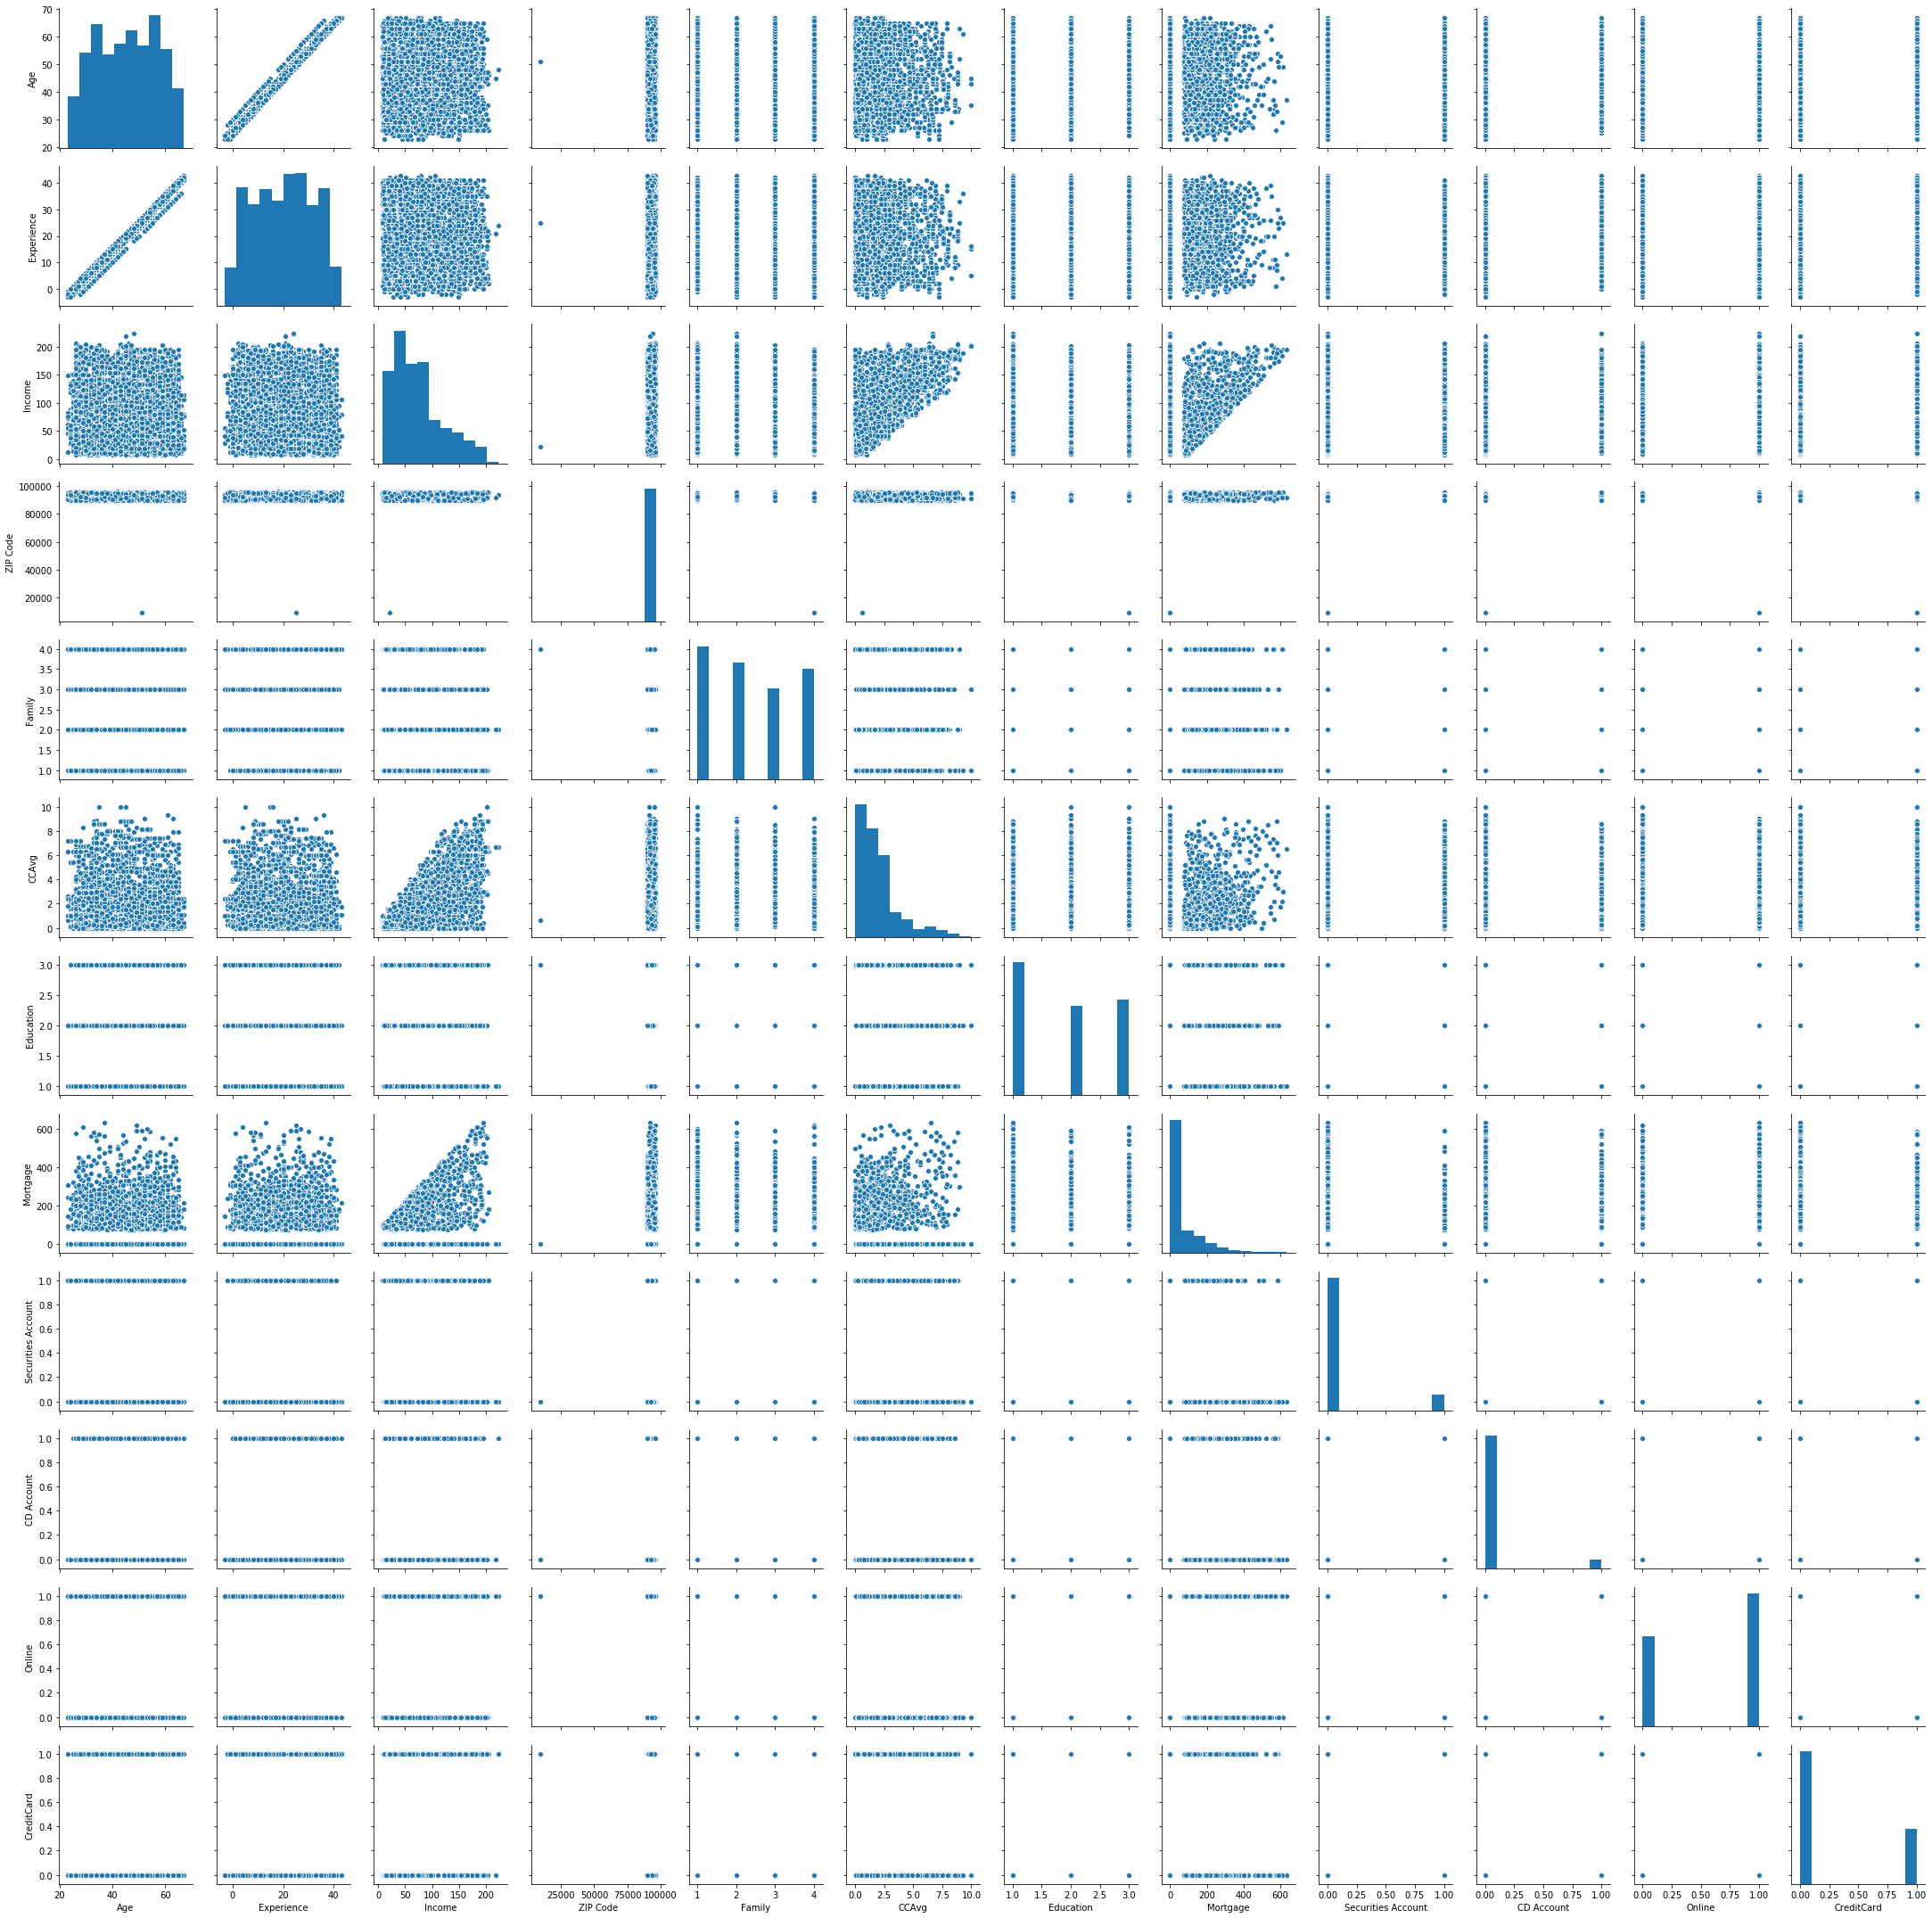

In [181]:
# draw pairplot to investigate distributions and correlations
sns.pairplot(df_data_x)

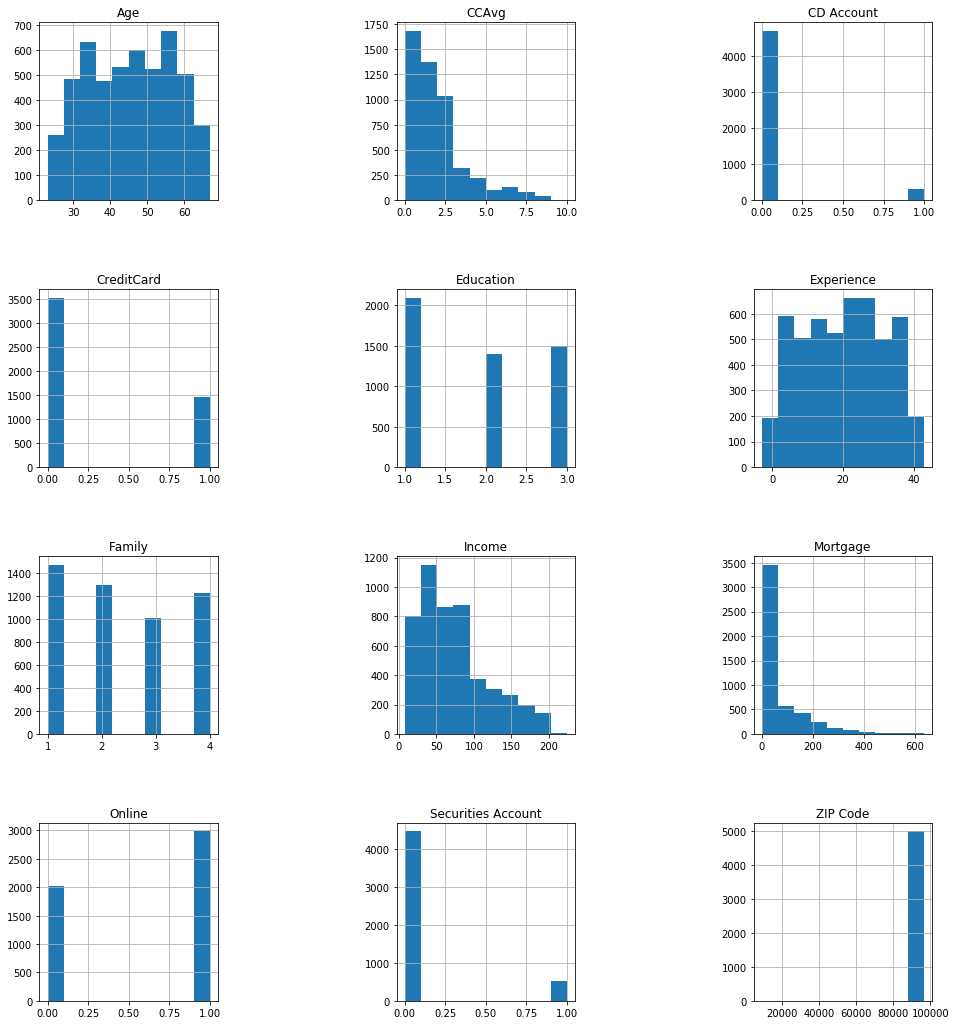

In [182]:
# Draw histograms of all attributes
column_list = list(df_data_x)

df_data_x[column_list].hist(figsize = (16,18))
plt.subplots_adjust(hspace=0.5, wspace=1) 
plt.show()

#### Comments: 
In general the distributions show that there are no outliers in any of the features. <br>
The distributions of Age and Experience follow close to normal distributions, which is not unexpected. <br>
The distributions of CCAvg (average spending on credit cards per month) and Income are skewed to the left. <br>
The distribution for Mortgage (Value of house mortgage if any) has a large number of zeros (no mortgage), and the rest of the distribution is also skewed to the left.<br>
The distributions of the categorical variables are not so meaningful, they will be better plotted as count plots.<br>
The distribution for ZIP code falls in a narrow band, this distribution will be plotted seperately to investigate further.

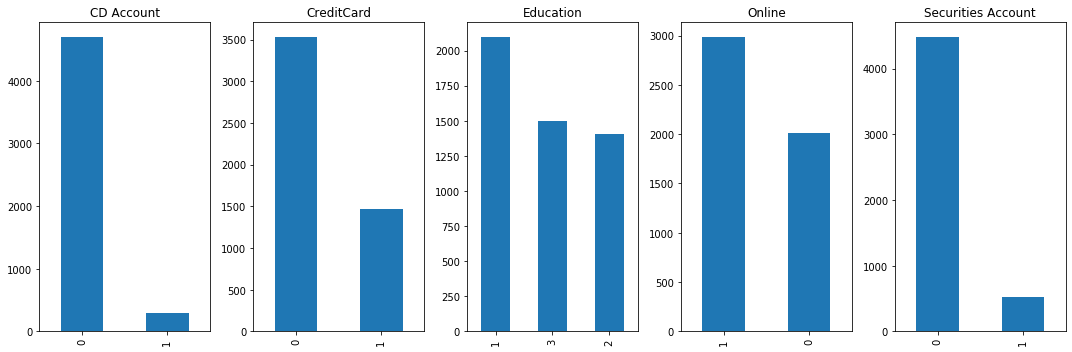

In [183]:
categorical_features = ["CD Account", "CreditCard", "Education", "Online", "Securities Account"]
fig, ax = plt.subplots(1, len(categorical_features),figsize=(15,5))

for i, categorical_feature in enumerate(df_data_x[categorical_features]):
    df_data_x[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
fig.tight_layout()


The CD Account and Securities Account show some imbalance, while the rest of the categorical features are more balanced.

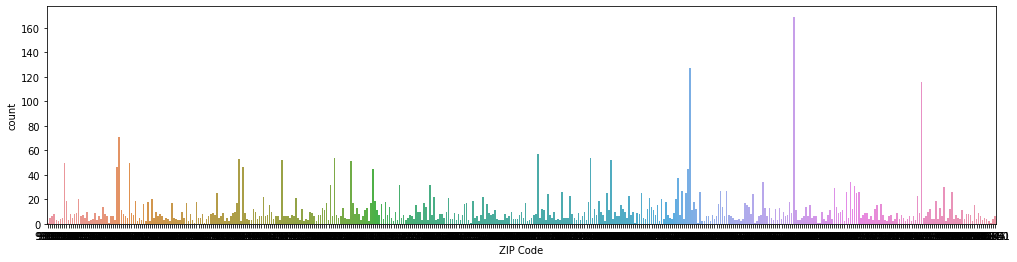

In [184]:
plt.figure(figsize=(17,4))
sns.countplot(df_data_x['ZIP Code'])

The countplot for zipcode shows that there is large variablity in the zipcode. This feature might be too "noisy" for much information to be extracted.

### 3.	Get the target column distribution. Your comments (5 marks)

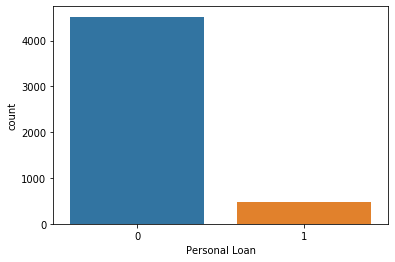

In [185]:
# plt.figure(figsize=(17,4))
sns.countplot(df_data_y)

In [186]:
loan_accepted = df_data_y[df_data_y == 1].count()
loan_declined = df_data_y[df_data_y == 0].count()
percentage_accepted = (loan_accepted/(loan_accepted+loan_declined))*100

print("The number of customers who took up a personal loan is {}".format(loan_accepted))
print("The number of customers who did not take up a personal loan is {}".format(loan_declined))

print("The percentage customers who took up a personal loan is {}".format(percentage_accepted) +"%")

The number of customers who took up a personal loan is 480
The number of customers who did not take up a personal loan is 4520
The percentage customers who took up a personal loan is 9.6%


#### Comments: 
The target variable is very imballanced. This imballance might affect the accuracy of the logistic regression model. The imbalance could be addressed with a technique like SMOTE (Synthetic Minority Over-sampling Technique). Care must be take that when the data is split into a train and test set that the relative weights of the calsses are maintained in these sets (stratification). The train_test_split library does this automatically.

In [189]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['Personal Loan'], margins=True)
    ct_res['Approved (%)'] = round(ct_res[1]/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [191]:
get_ct(df_data_raw,'Education')

Personal Loan,0,1,Approved (%)
Education,,,
1,2003,93,4.44
2,1221,182,12.97
3,1296,205,13.66
All,4520,480,9.60


### 4.	Split the data into training and test set in the ratio of 70:30 respectively (5 marks)

In [192]:
x_train,x_test,y_train,y_test=train_test_split(df_data_x,df_data_y,test_size=0.3,random_state=1)

# check that class ratio is maintained in train_test_split
y_train_loan_accepted = y_train[y_train == 1].count()
y_train_loan_declined = y_train[y_train == 0].count()

y_train_percentage_accepted = (y_train_loan_accepted/(y_train_loan_accepted+y_train_loan_declined))*100

print("Train: {}".format(y_train_percentage_accepted) +"%")


Train: 9.457142857142857%


In [193]:
y_test_loan_accepted = y_test[y_test == 1].count()
y_test_loan_declined = y_test[y_test == 0].count()

y_test_percentage_accepted = (y_test_loan_accepted/(y_test_loan_accepted+y_test_loan_declined))*100

print("Test: {}".format(y_test_percentage_accepted) +"%")

Test: 9.933333333333334%


#### Comments: 
Class ratio has been maintained to a reasonable degree.

### 5.	Use Logistic Regression model to predict the likelihood of a customer buying personal loans. You can also use other classification models you may know of but that won’t be counted towards your evaluation.   (25 marks)

#### Logistic regression model: 

In [194]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Fit the model on training data
model = LogisticRegression(solver="liblinear", class_weight='balanced')
model.fit(x_train, y_train)
#predict on test
y_predict = model.predict(x_test)


# check predictions on training set to check for overfitting
y_predict_train = model.predict(x_train)


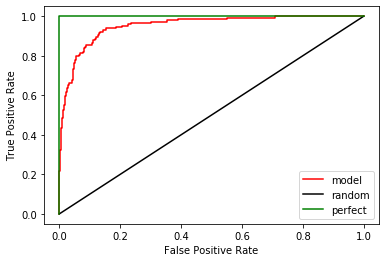

In [195]:
y_predict_prob = model.predict_proba(x_test)
y_predict_prob_1 = y_predict_prob[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob_1)

plt.plot(fpr, tpr,'r-',label = 'model')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Light gradient boosting machine model: 

In [196]:
#  test Light Gradient Boosting Machine
from lightgbm import LGBMClassifier
import lightgbm as lgb

model_LGBM = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   is_unbalance = 'true', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

clf = model_LGBM.fit(x_train, y_train, eval_metric='roc_auc')

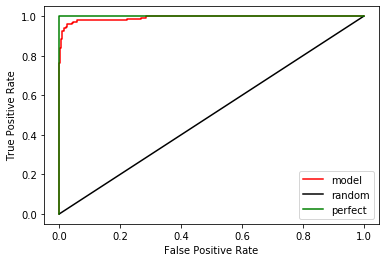

In [197]:
y_predict_prob = model_LGBM.predict_proba(x_test)
y_predict_prob_1 = y_predict_prob[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob_1)

plt.plot(fpr, tpr,'r-',label = 'model')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### 6.	Print the confusion matrix for all the above models (5 marks)

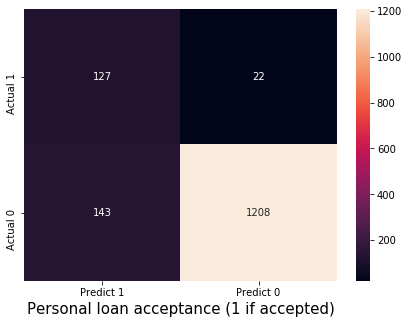

Accuracy score:  0.89
Recall score:  0.8523489932885906
Precision score:  0.4703703703703704
F1 score:  0.6062052505966588
AUROCC score:  0.8732507364666491

Check for overfitting:
Accuracy score (training):  0.8982857142857142
Recall score (training):  0.9003021148036254
Precision score (training):  0.47987117552334946
F1 score (training):  0.6260504201680672


In [198]:
# plot confusion matrix for Logistic Regression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix, precision_recall_fscore_support, roc_curve, roc_auc_score


cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["Actual 1","Actual 0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
ax = sns.heatmap(df_cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Personal loan acceptance (1 if accepted)', fontsize=15)
plt.show()

print('Accuracy score: ', accuracy_score(y_test,y_predict))
print('Recall score: ', recall_score(y_test,y_predict))
print('Precision score: ', precision_score(y_test,y_predict))
print('F1 score: ', f1_score(y_test,y_predict))
print('AUROCC score: ', roc_auc_score(y_test,y_predict))
print()
print('Check for overfitting:')
print('Accuracy score (training): ', accuracy_score(y_train,y_predict_train))
print('Recall score (training): ', recall_score(y_train,y_predict_train))
print('Precision score (training): ', precision_score(y_train,y_predict_train))
print('F1 score (training): ', f1_score(y_train,y_predict_train))

#### Comments: 
The evaluation metrics indicate that the logistic regression model is not overfit.

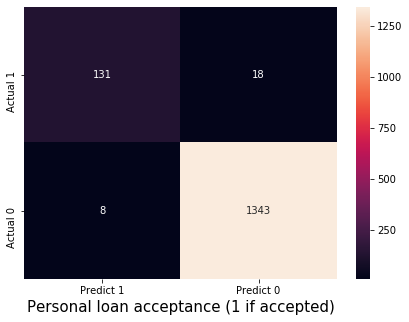

Accuracy score:  0.9826666666666667
Recall score:  0.8791946308724832
Precision score:  0.9424460431654677
F1 score:  0.9097222222222223
AUROCC score:  0.9366365456360936


In [199]:
# plot confusion matrix for Light Gradient Boosting Machine
threshold = 0.5
y_pred_1_list = []
y_pred_1_list = (y_predict_prob_1 > threshold).astype(int)
y_pred_1 = pd.DataFrame(y_pred_1_list)
y_pred_1
# y_test_1 = y_test.drop('Unnamed: 0',1)


# Creates a confusion matrix
cm=metrics.confusion_matrix(y_test, y_pred_1, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["Actual 1","Actual 0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
ax = sns.heatmap(df_cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Personal loan acceptance (1 if accepted)', fontsize=15)


plt.show()
print('Accuracy score: ', accuracy_score(y_test,y_pred_1))
print('Recall score: ', recall_score(y_test,y_pred_1))
print('Precision score: ', precision_score(y_test,y_pred_1))
print('F1 score: ', f1_score(y_test,y_pred_1))
print('AUROCC score: ', roc_auc_score(y_test,y_pred_1))

### 7.	Give your reasoning on how can the model perform better. In case you have used various models, mention the best model in this case and why does it performs better(optional)? (5 marks)

The following techniques might improve the performance of the logistic regression model:
1. Improving the class imbalance with an oversampling technique like SMOTE
2. Feature scaling or normalisation
3. Making use of a different scoring metric than Log-loss
4. Feature engineering: combine features, make features non-linear (x^2)
5. Changing the threshold from the default 0.5. The reason to do this however comes from the information gained from the predictions on the test set, so this might be introducing over-fitting into the model.

The LGBM model perfroms the best. The improved performance of the LGBM model could be due to:
1. The ability of the model to capture non-linear relationships in the data.
2. Boosted trees allow for more flexible decision boundaries - it does not require linear boundaries like logistic regression.

### 8 (extra).	Test model with ZIP code removed

In [200]:
df_data_x_red = df_data_x.copy().drop(['ZIP Code'],axis=1)

In [201]:
df_data_x_red

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,1,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,3,0,0,0,1,0
4996,30,4,15,4,0.4,1,85,0,0,1,0
4997,63,39,24,2,0.3,3,0,0,0,0,0
4998,65,40,49,3,0.5,2,0,0,0,1,0


In [202]:
x_train_red,x_test_red,y_train,y_test=train_test_split(df_data_x_red,df_data_y,test_size=0.3,random_state=1)

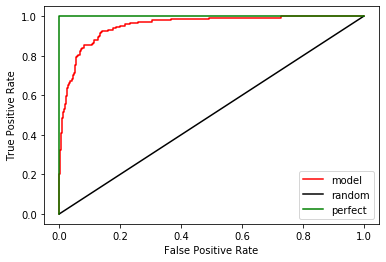

Accuracy score:  0.8906666666666667
Recall score:  0.8590604026845637
Precision score:  0.47232472324723246
F1 score:  0.6095238095238095
AUROCC score:  0.8766064411646356


In [203]:
# Fit the model on training data
model = LogisticRegression(solver="liblinear", class_weight='balanced')
model.fit(x_train_red, y_train)
#predict on test
y_predict = model.predict(x_test_red)
y_predict_prob = model.predict_proba(x_test_red)

y_predict_prob_1 = y_predict_prob[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob_1)

plt.plot(fpr, tpr,'r-',label = 'model')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print('Accuracy score: ', accuracy_score(y_test,y_predict))
print('Recall score: ', recall_score(y_test,y_predict))
print('Precision score: ', precision_score(y_test,y_predict))
print('F1 score: ', f1_score(y_test,y_predict))
print('AUROCC score: ', roc_auc_score(y_test,y_predict))

Comment: this indicated that there was no information gained from the ZIP code feature (evaluation metrics for model with and without ZIP code are almost identical).